In [ ]:
# file management
import sys
import shutil
import urllib
import tarfile
import zipfile
from pathlib import Path
from copy import deepcopy
import pickle

import os

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# for readability
from typing import Iterable
from tqdm.notebook import tqdm, tnrange


import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path, mode="tar"):
    print("Extracting dataset... (it may take a while...)")
    if mode == "tar":
      with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    elif mode == "zip":
      with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("Extraction completed!")

In [ ]:
train_url = "https://drive.usercontent.google.com/download?id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2&export=download&authuser=0&confirm=t&uuid=9004532d-1162-47b2-985c-492039597222&at=APZUnTWm8D1ZM5_aa68vV6nRf9FA:1705400593770"
train_dataset_name = "EFR_train_dataset.json"
eval_url = "https://drive.usercontent.google.com/download?id=1wOgwT7Y9C3e4XIwecodTeO1acrbyIwkm&export=download&authuser=0&confirm=t&uuid=e4720599-94e5-4131-901b-702ca969911b&at=APZUnTWVa93R-4Dj4LTvBIIwODRr:1705754234489"
eval_dataset_name = "EFR_eval_dataset.json"
test_url = "https://drive.usercontent.google.com/download?id=1iS3Gjyi30e4gu7dRGSY5beOG4KFAB9E-&export=download&authuser=0&confirm=t&uuid=41eabfc2-eb88-47f2-86ae-38c31ef764a9&at=APZUnTX1AwYtJ_oyDVv7G2Lx34r1:1705754302262"
test_dataset_name = "EFR_test_dataset.json"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

train_dataset_json_path = dataset_folder.joinpath(train_dataset_name)
eval_dataset_json_path = dataset_folder.joinpath(eval_dataset_name)
test_dataset_json_path = dataset_folder.joinpath(test_dataset_name)

if not train_dataset_json_path.exists():
    download_dataset(train_dataset_json_path, train_url)
if not eval_dataset_json_path.exists():
    download_dataset(eval_dataset_json_path, eval_url)
if not test_dataset_json_path.exists():
    download_dataset(test_dataset_json_path, test_url)

Current work directory: /kaggle/working


download?id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2&export=download&authuser=0&confirm=t&uuid=9004532d-1162-47b2-985…

Download complete!


download?id=1wOgwT7Y9C3e4XIwecodTeO1acrbyIwkm&export=download&authuser=0&confirm=t&uuid=e4720599-94e5-4131-901…

Download complete!


download?id=1iS3Gjyi30e4gu7dRGSY5beOG4KFAB9E-&export=download&authuser=0&confirm=t&uuid=41eabfc2-eb88-47f2-86a…

Download complete!


In [ ]:
global_df = pd.read_json(train_dataset_json_path)

In [ ]:
# Replaces NaN values by 0 in lists of given row
def remove_nan(row):
    return [0 if pd.isna(x) else x for x in row]

# Checks that there are no NaN values in lists of given row
def nan_free(column):
    return all(all(pd.notna(x) for x in row) for row in column)

global_df['triggers'] = global_df['triggers'].apply(remove_nan)
nan_free(global_df['triggers'])

True

In [ ]:
def transform_df(df):
    # Concatenate each utterance to their respective emotion
    df['concat_utterance'] = df.apply(lambda row: [a + " " + b for a, b in zip(row['utterances'], row['emotions'])], axis=1)

    # Create a new identical row for each element in the list of trigger target
    df = global_df.explode('triggers', ignore_index=True)

    # Create a new column to keep index of each utterance's trigger
    df['utterance_index'] = df.groupby('episode').cumcount() + 1

    # Concatenate a pointer "TRIGGER" at the end of the correct utterance
    df['concat_utterance'] = df.apply(lambda row: [word + ' TRIGGER' if i == row['utterance_index']-1 else word for i, word in enumerate(row['concat_utterance'])], axis=1)

    return df[['episode', 'concat_utterance', 'triggers', 'utterance_index']]

df = transform_df(global_df)

In [ ]:
df.head(10)

,episode,concat_utterance,triggers,utterance_index
0,utterance_0,[also I was the point person on my company's t...,0.0,1
1,utterance_0,[also I was the point person on my company's t...,0.0,2
2,utterance_0,[also I was the point person on my company's t...,0.0,3
3,utterance_0,[also I was the point person on my company's t...,1.0,4
4,utterance_0,[also I was the point person on my company's t...,0.0,5
5,utterance_1,[also I was the point person on my company's t...,0.0,1
6,utterance_1,[also I was the point person on my company's t...,0.0,2
7,utterance_1,[also I was the point person on my company's t...,0.0,3
8,utterance_1,[also I was the point person on my company's t...,0.0,4
9,utterance_1,[also I was the point person on my company's t...,0.0,5


In [ ]:
df['concat_utterance'][1]

["also I was the point person on my company's transition from the KL-5 to GR-6 system. neutral",
 "You must've had your hands full. neutral TRIGGER",
 'That I did. That I did. neutral',
 "So let's talk a little bit about your duties. neutral",
 'My duties?  All right. surprise']

In [ ]:
# Assigns 80% of data to training set, without shuffling
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Assigns remaining 20% of data to test and validation set, without shuffling
test_df, val_df = train_test_split(test_df, test_size=0.5, shuffle=False)

In [ ]:
print(len(train_df))
print(len(test_df))
print(len(val_df))

28000
3500
3500


## Model definition - Triggers

In [ ]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

thresholds = {}

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = max([len(tokenizer(" ".join(l))['input_ids']) for l in val_df["concat_utterance"]])
print(MAX_LEN)

413


In [ ]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.utterances = dataframe.concat_utterance
        self.targets = self.data.triggers
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):

        utterances = str(self.utterances[index])
        utterances = " ".join(utterances.split())

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
print("TRAIN Dataset: {}".format(train_df.shape))
print("VAL Dataset: {}".format(val_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

training_set = CustomDataset(train_df.reset_index(), tokenizer, MAX_LEN)
validation_set = CustomDataset(val_df.reset_index(), tokenizer, MAX_LEN)
test_set = CustomDataset(test_df.reset_index(), tokenizer, MAX_LEN)

TRAIN Dataset: (28000, 4)
VAL Dataset: (3500, 4)
TEST Dataset: (3500, 4)


In [ ]:
tokenizer.decode(training_set[1]['ids'])

'[CLS] [ " also i was the point person on my company\'s transition from the kl - 5 to gr - 6 system. neutral ", " you must\'ve had your hands full. neutral trigger ",\'that i did. that i did. neutral \', " so let\'s talk a little bit about your duties. neutral ",\'my duties? all right. surprise\'] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)

        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

model = BERTClass()
model.to(device)

# Freezes all layers (mostly Bert) apart from final dense layer if activated
freeze = False
if freeze:
    for name, param in model.named_parameters():
        if 'l3' not in name: # classifier layer
          param.requires_grad = False

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# Sets up optimizer and scheduler
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)
# total_steps = len(training_loader)*EPOCHS
# scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # Forward pass
        outputs = model(ids, mask, token_type_ids)
        outputs = outputs.flatten()

        # Clear previous gradients
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%1000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Take a step using computer gradient
        optimizer.step()

In [ ]:
def validation(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            # Append batch targets and predictions to lists
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
# Selects best threshold to calculate F1-score
def select_threshold(outputs, targets):
    results = {}
    for tr in np.arange(0.1, 0.9, 0.01):
        tr = round(tr, 2)
        predictions= np.array(outputs) >= tr
        results[tr] = metrics.f1_score(targets, predictions, average="macro")
    return max(results,key=results.get)

# Calculates accuracy and F1-score on validation data
def get_val_metrics(outputs, targets):
    threshold = select_threshold(outputs, targets)
    outputs = np.array(outputs) >= threshold
    return metrics.accuracy_score(targets, outputs), metrics.f1_score(targets, outputs, average='macro')

In [ ]:
# Setting random seed for reproducibility
seeds = [123, 246, 369, 12, 24]

# Setting random seed for numpy and pytorch
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


for seed in seeds:
    set_seeds(seed)
    print("CURRENTLY RUNNING MODEL FOR SEED {0}".format(seed))
    for epoch in range(EPOCHS):
        train(epoch)
        outputs, targets = validation(model)
        val_accuracy, val_f1 = get_val_metrics(outputs, targets)

        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation F1-score: {val_f1:.4f}")

    torch.save(model, "{0}_model_seed_{1}.pth".format('freeze' if freeze else 'full', seed))
    model.reset_parameters()

CURRENTLY RUNNING MODEL FOR SEED 123
Epoch: 0, Loss:  0.7806397676467896
Epoch: 0, Loss:  0.5214646458625793
Epoch: 0, Loss:  0.5737794637680054
Epoch: 0, Loss:  0.16036275029182434
Validation Accuracy: 0.8306
Validation F1-score: 0.7201
CURRENTLY RUNNING MODEL FOR SEED 246
Epoch: 0, Loss:  0.5033544301986694
Epoch: 0, Loss:  0.12663865089416504
Epoch: 0, Loss:  0.6984211802482605
Epoch: 0, Loss:  0.1593845784664154
Validation Accuracy: 0.8429
Validation F1-score: 0.7284
CURRENTLY RUNNING MODEL FOR SEED 369
Epoch: 0, Loss:  0.6752235293388367
Epoch: 0, Loss:  0.0734274834394455
Epoch: 0, Loss:  0.08232768625020981
Epoch: 0, Loss:  0.2851330041885376
Validation Accuracy: 0.8471
Validation F1-score: 0.7419
CURRENTLY RUNNING MODEL FOR SEED 12
Epoch: 0, Loss:  1.108656406402588
Epoch: 0, Loss:  0.17615142464637756
Epoch: 0, Loss:  0.3591729998588562
Epoch: 0, Loss:  0.36471840739250183
Validation Accuracy: 0.8463
Validation F1-score: 0.7387
CURRENTLY RUNNING MODEL FOR SEED 24
Epoch: 0, Los

In [ ]:
def get_sequence_f1_scores(outputs, targets):
    utterance_dict = {}
    f1_scores = []

    # Creates dictionary that contains a list of predictions and targets for each utterance/dialogue
    for output, target, index in zip(outputs, targets, df['episode']):
        if index in utterance_dict:
            utterance_dict[index]['output'].append(output.tolist()[0])
            utterance_dict[index]['target'].append(target)
        else:
            utterance_dict[index] = {'output': [output.tolist()[0]], 'target': [target]}

    # Computes F1-score for each utterance/dialogue
    for key, utterance in utterance_dict.items():
        pred = utterance['output']
        target = utterance['target']
        f1_scores.append(metrics.f1_score(target, pred, average='macro'))

    sequence_f1 = np.mean(f1_scores)
    unrolled_sequence_f1 = metrics.f1_score(targets, outputs, average='macro')

    return sequence_f1, unrolled_sequence_f1

In [ ]:
for seed in seeds:
    print(f"Running seed {seed}")
    if freeze:
        model = torch.load("freeze_model_seed_{0}.pth".format(seed))
    else:
        model = torch.load("full_model_seed_{0}.pth".format(seed))
    # Select best threshold to be used on the test dataset
    outputs, targets = validation(model)
    threshold = select_threshold(outputs, targets)
    outputs = np.array(outputs) >= threshold
    thresholds[seed] = threshold

    sequence_f1, unrolled_sequence_f1 = get_sequence_f1_scores(outputs, targets)
    print(f"Sequence F1 Score = {sequence_f1}")
    print(f"Unrolled Sequence F1 Score = {unrolled_sequence_f1}")

Sequence F1 Score = 0.6984493270130043
Unrolled Sequence F1 Score = 0.7200717145111828
Sequence F1 Score = 0.7107521887723869
Unrolled Sequence F1 Score = 0.7284148342780266
Sequence F1 Score = 0.7195217405155188
Unrolled Sequence F1 Score = 0.7418941317959551
Sequence F1 Score = 0.7224086295078417
Unrolled Sequence F1 Score = 0.7386712676067284
Sequence F1 Score = 0.7368970634037277
Unrolled Sequence F1 Score = 0.7495529741689821


In [ ]:
def test(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
for seed in seeds:
    print(f"Running seed {seed}")
    if freeze:
        model = torch.load("freeze_model_seed_{0}.pth".format(seed))
    else:
        model = torch.load("full_model_seed_{0}.pth".format(seed))
    outputs, targets = test(model)
    outputs = np.array(outputs) >= thresholds[seed]

    sequence_f1, unrolled_sequence_f1 = get_sequence_f1_scores(outputs, targets)
    print(f"Sequence F1 Score = {sequence_f1}")
    print(f"Unrolled Sequence F1 Score = {unrolled_sequence_f1}")

Running seed 123
Sequence F1 Score = 0.674465156061548
Unrolled Sequence F1 Score = 0.7041256734848884
Running seed 246
Sequence F1 Score = 0.678280568876201
Unrolled Sequence F1 Score = 0.7058532054470836
Running seed 369
Sequence F1 Score = 0.6932898465131987
Unrolled Sequence F1 Score = 0.70474811693913
Running seed 12
Sequence F1 Score = 0.6912687558338542
Unrolled Sequence F1 Score = 0.7106278361981957
Running seed 24
Sequence F1 Score = 0.6947350091262108
Unrolled Sequence F1 Score = 0.7193942154369856


In [ ]:
def average_f1_score():
    sequence_f1_scores = []
    unrolled_sequence_f1_scores = []

    for seed in seeds:
        if freeze:
            model = torch.load("freeze_model_seed_{0}.pth".format(seed))
        else:
            model = torch.load("full_model_seed_{0}.pth".format(seed))

        model.eval()
        outputs, targets = test(model)
        outputs = np.array(outputs) >= thresholds[seed]

        sequence_f1, unrolled_sequence_f1 = get_sequence_f1_scores(outputs, targets)
        sequence_f1_scores.append(sequence_f1)
        unrolled_sequence_f1_scores.append(unrolled_sequence_f1)


    average_f1 = sum(sequence_f1_scores)/len(sequence_f1_scores)
    average_unrolled_f1 = sum(unrolled_sequence_f1_scores)/len(unrolled_sequence_f1_scores)

    print(f"Average Sequence F1 Score = {sequence_f1}")
    print(f"Average Unrolled Sequence F1 Score = {unrolled_sequence_f1}")

In [ ]:
average_f1_score()

[0.6859470800451952, 0.6813020245948789, 0.6727882178926583, 0.6853618039439726, 0.6885031258000684]
[0.7041256734848884, 0.7058532054470836, 0.70474811693913, 0.7106278361981957, 0.7193942154369856]
Average Sequence F1 Score = 0.6885031258000684
Average Unrolled Sequence F1 Score = 0.7193942154369856


##Error analysis

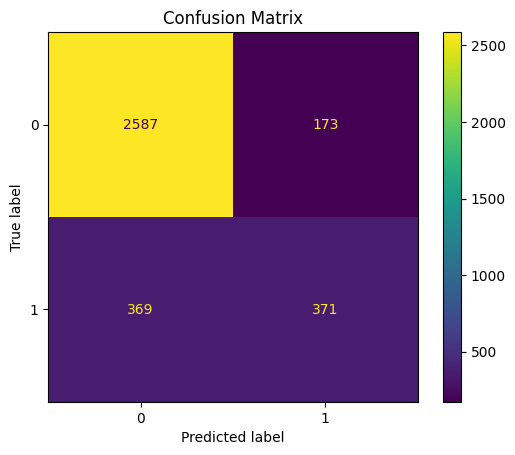

In [ ]:
# Confusion Matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
from sklearn import metrics

y_true = targets
y_pred = outputs

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

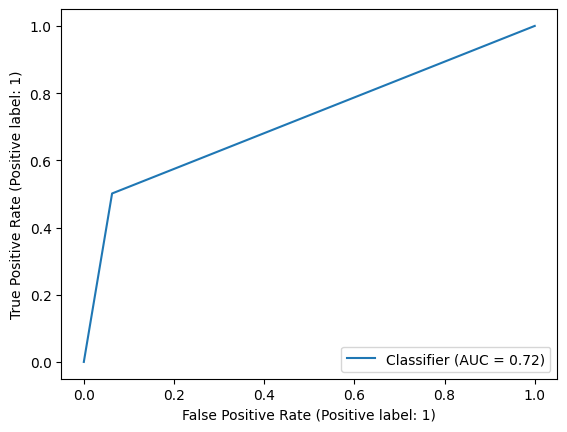

In [ ]:
# ROC Curve

metrics.RocCurveDisplay.from_predictions(y_true, y_pred)
plt.show()

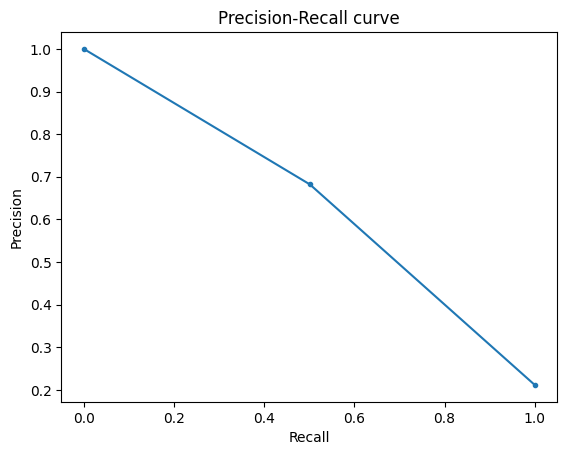

In [ ]:
# PrecisionRecall

precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()
